# Задание 8

## 1. Wiki philosophy (0.5 баллов)
Существует шуточный «закон Философии» для статей Википедии: если переходить по
первой нормальной ссылке в статье, то рано или поздно мы придем на статью о философии.
Ваша задача заключается в том, чтобы проверить этот закон.
Для этого нужно написать программу, которая получает на вход ссылку на статью Википедии, а потом циклически переходит по первой нормальной ссылке и повторяет эту операцию
(до тех пор, пока не будет достигнута статья о философии, или ссылки не зациклятся). Нормальной ссылкой будем называть ссылку, которая находится в основном содержании статьи,
не в инфобоксах и не в служебных блоках, написана синим цветом (красный соответствует
несуществующей статье), не курсивом, не являтся сноской и не находится в скобках.

<b>Результат</b> должен представлять из себя несколько статистик (проверьте не менее 100 стр., <i>больше - лучше</i>):
* Описание алгоритма, как вы решали, стр. по философии или нет?
* Количество начальных ссылок vs Количество конечных тем страниц (0 - стр. не по философии, 1 - по философии).
* Гистограмма длин путей.
* Соотношений успешных и неуспешных запросов.
* Что еще можно тут придумать? :)

<b>Обратите внимание</b>, что для проверки нормальности не обязательно разбирать таблицы стилей и
проверять цвет и т.п., достаточно сделать, чтобы программа работала для текущей верстки
википедии (например, можно использовать атрибут class у тегов).
Для удобства проверки сделайте, чтобы последовательность переходов выводилась на
экран.

<b>Внимание.</b> Чтобы не создавать большую нагрузку на сервер Википедии, сделайте так,
чтобы ваша программа делала не более 2-х запросов в секунду. Для этого воспользуйтесь
функцией sleep из модуля time.

<b>PS</b> Лучше выполнять не в ipython notebook, а прислать отчет в pdf и код.

1. Алгоритм.<br>

    Алгоритм таков: берём страницу, берём все нормальные ссылки на ней, переходим по первой, всё повторяем. Если вдруг на какой-то странице нет нормальных ссылок или же они кончились, возвращаемся на предыдущую страницу и берём следующую по счёту ссылку. И так до тех пор, пока не:<br>
    1.1. Найдём страницу по философии.<br>
    1.1. Получим путь максимальной длины.<br>
    1.2. Получим, что с начальной страницы нет пути длины максимальной длины.<br>
    В случае возникновеня циклов -- берём следующую нормальную ссылку со страницы, на которой уже были.

    Изначально планировалось искать страницу "Философия", однако так как условие гласит, что нужно определять, является ли страница страницей по теме, связанной философией, то планировалось добавить некоторые критерии: поиск по странице корня "философ"/просмотр инфобокса на наличие там категории и т.п.<br>
    Однако на первом этапе выполнялся лишь поиск страницы "Философия", и, как выяснилось, она действительно находится очень часто за неболее чем 40 шагов, в связи с чем дополнительные критерии не были добавлены. (Неудачные примеры не имеют ссылок на странице.)

    Итог (вкратце): переходим по первой нормальной ссылке пока можем, надеемся, что в скором времени на пути встретится страница "Философия".<br>

2. Начальные ссылки.<br>

    Все начальные ссылки брались рандомно с помощью случайной страницы на Википедии. Как можно видеть по результатам -- многие из них далеки от тем, связанных с философией.<br>

3. Гистограмма длин путей и соотношение успешных/неуспешных запросов.<br>

    См. ниже.

In [44]:
import requests
import bs4
import time
import sys

class InitialSettings():
    
    def __init__(self):
        self.MAINLINK = "https://ru.wikipedia.org"
    
        self.SESSION = requests.Session() 
        self.SESSION.headers.update({ 'Referer': self.MAINLINK,
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
            })

    def getSession(self):
        return self.SESSION
    
    def getMainLink(self):
        return self.MAINLINK

settings = InitialSettings()

class ExceptionNoLinks(Exception):
    
    def __init__(self, pageName):
        self.pageName = pageName
        
    def __str__(self):
        return "Page '{0}' hasn't links".format(self.pageName)

class DataLoader():

    def __init__(self, target, max_links, firstLink=None):
        self.target = target
        self.max_links = max_links
        
        if firstLink == None:
            link = settings.getMainLink() + "/wiki/Служебная:Случайная_страница/"
        else:
            link = firstLink
        
        page = settings.getSession().get(link).text
        soup = bs4.BeautifulSoup(page, 'html5lib')
        link = soup.find('link', {'rel' : 'canonical'})['href']
        name = soup.find('h1').text
        
        self.links = [[name, link, 0]] #Название страницы, ссылка, номер страницы для поиска

    def getNextLink(self, parentPageLink, number):
        
        def deleteBrackets(paragraph):
            par = '_' + str(paragraph)
            idx = 0
            count = 0
            i = 0 
            notLink = True
            while True:
                if len(par) == i:
                    break
                if par[i] == '(':
                    if par[i-1] != '_':
                        idx = i
                    else:
                        notLink = False
                    count += 1
                if par[i] == ')':
                    count -= 1
                    if count == 0:
                        if notLink:
                            par = par[:idx] + par[i+1:]
                            i = idx
                        notLink = True
                i += 1
            
            return par[1:]
        
        try:
            page = settings.getSession().get(parentPageLink).text
        except:
            raise ExceptionNoLinks(parentPageLink)
        time.sleep(0.5)
        
        pageSoup = bs4.BeautifulSoup(page, 'html5lib')
        try:
            # Нужно искать:
            # 1. Ссылки в основном содержании статьи -- OK.
            # 2. Не в инфобоксах и не в служебных блоках -- пока не ясно, но как наткнусь, пойму.
            # Если это про блоки справа и т.п. -- тогда OK.
            # 3. Красные ссылки -- OK.
            # 4. Курсив -- OK.
            # 5. Сноски -- OK.
            # 6. Скобки -- OK.
            
            pageBody = pageSoup.find('div', {'class': 'mw-parser-output'}) #П.1.
            paragraphs = pageBody.find_all('p', recursive=False)
            uls = pageBody.find_all('ul', recursive=False)
            lis = list(map(lambda x: x.find_all('li'), uls))
            
            #print(lis)
            
            links = []
            for paragraph in paragraphs:

                #print(paragraph)
                par = deleteBrackets(paragraph)
                par = bs4.BeautifulSoup(par, 'html5lib').find('p')
                
                linksInParagraph = par.find_all('a', recursive=False)
                for link in linksInParagraph:
                    if "redlink" in str(link):
                            continue
                    #print(link.text)
                    links.append(link)
                    
            for li in lis:
                for l in li:
                    par = deleteBrackets(l)
                    par = bs4.BeautifulSoup(par, 'html5lib').find('li')

                    linksInParagraph = par.find_all('a', recursive=False)
                    for link in linksInParagraph:
                        if "redlink" in str(link):
                            continue
                        if "mw-magiclink-isbn" in str(link):
                            continue
                        #print(link, link.text)
                        links.append(link)
        
            #print('----')
        
        except Exception as e:
            #print(e)
            raise ExceptionNoLinks(parentPageLink)
        
        #print(links)
        
        try:
            link = links[number]
        except Exception as e:
            #print(e)
            raise ExceptionNoLinks(parentPageLink) 

        return link['href'], link['title']
    
    def getFirstPageName(self):
        return self.links[0][0]
    
    def run(self, target):
        
        while True:
            
            #print(self.links)
            
            try:
                try:
                    link, title = self.getNextLink(self.links[-1][1], self.links[-1][2])
                    #print(link, title)
                except ExceptionNoLinks as e:
                    #Удалим последнюю страницу, а на предыдущей возьмём следующую ссылку
                    self.links.pop()
                    self.links[-1][2] += 1
                    continue
            except Exception as e: #На главной странице закончились ссылки
                print(e)
                raise ExceptionNoLinks("Ups")
            
            if 'http' != link[:4]:
                link = settings.getMainLink() + link
            
            #Если вдруг возник цикл
            idx = 0
            linkCopy = self.links.copy()
            linkCopy.reverse()
            #Почему не работает, когда вместо lk стоит link?
            for lk in linkCopy:
                try:
                    if lk[0] == title:
                        idx = lk[2] + 1
                        break
                except Exception as e:
                    print(e)
            
            self.links.append([title, link, idx])
            
            #printLinks(self.links)
            
            if len(self.links) >= self.max_links:
                break
            if title == target:
                break
                
        return (self.target in list(map(lambda x: x[0], self.links)), self.links)

def printLinks(links, output=sys.stdout):
    output.write("Path:\n")
    output.write("\n----------------------\n")
    for p in links:
        output.write("Page name: {0}, next link number: {1}, link: {2}\n".format(p[0], p[2], p[1]))
        #print("Page name: {0}, next link number: {1}".format(p[0], p[2]))#, p[1]))
    output.write("\n----------------------\n")
            
def runExperiment(target, pathLength, firstLink=None):
    dataLoader = DataLoader(target, pathLength, firstLink)
    
    pageName = dataLoader.getFirstPageName()
    
    file = open("paths/" + pageName + '.txt', 'w')
    
    file.write('Target: {0}, max_length: {1}\n'.format(target, pathLength))
    
    try:
        isFound, links = dataLoader.run(target)
    except ExceptionNoLinks as e:
        file.write("Нет ни одного пути длиной {0}\n".format(pathLength))
        file.close()
        print('End of experiment')
        return

    if not isFound:
        file.write("{0} in not found\n".format(target))
    
    printLinks(links, file)
    
    file.close()
    
    print('End of experiment')
    
def runExperiments(countExperiments):
    #runExperiment("Философия", 20, "https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D1%80%D0%B8%D1%81%D1%81%D0%B0")
    for i in range(countExperiments):
        runExperiment("Философия", 40)

runExperiments(20)


End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment
End of experiment


In [45]:
from collections import Counter
import os

directory = "./paths/"

files = os.listdir(path=directory)

success = len(files)
unsuccessNotFound = 0
unsuccessNoLinks = 0

counter = Counter()

for fileName in files:
    if fileName.endswith(".txt"):
        file = open(directory + fileName, 'r')
        lines = file.readlines()
        file.close()
        
        start = 0
        finish = 0
        isSuccess = True
        for i in range(len(lines)):
            if not isSuccess:
                break
            if 'not found' in lines[i]:
                unsuccessNotFound += 1
                success -= 1
                isSuccess = False
                continue
            if 'Нет ни одного пути длиной' in lines[i]:
                unsuccessNoLinks += 1
                success -= 1
                isSuccess = False
                continue
            if lines[i].startswith('---'):
                start = i
                break
        if not isSuccess:
            continue
        for i in range(len(lines)-1, 0, -1):
            if lines[i].startswith('---'):
                finish = i
                break
                
        pathLength = finish - start - 2
        #print(fileName, pathLength)
        
        counter[str(pathLength)] += 1
                
    else:
        success -= 1
        
print('Success:', success)
print('Unsuccess: not found:', unsuccessNotFound)
print('Unsuccess: no links:', unsuccessNoLinks)

Success: 222
Unsuccess: not found: 0
Unsuccess: no links: 3


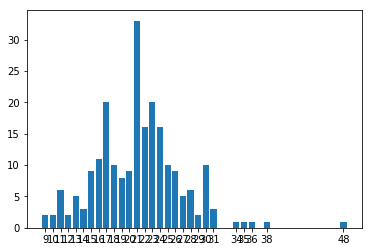

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
 
x = list(map(lambda x: int(x), counter.keys()))
y = counter.values()
plt.bar(x,y)
plt.xticks(x)
plt.show()

## 2. Books lib (0.5 баллов)
Напишите сайт-библиотеку для книг. Он должен удовлетворять следующему функционалу:
* Иметь одну главную страницу со списком авторов и ниже их произведений.
* Можно кликнуть на автора и получить список его произведений на отдельной стр.
* Можно кликнуть на книгу и получить текст книги на отдельной стр.
* Оформление и улучшение функционала приветствуются. Но можно обойтись заголовками и ссылками.

<b>Особенности реализации</b>:
* Список книг и авторов заранее не задан и должен быть создан автоматически. (<i>как - понятно из следующего описания</i>)
* Все книги хранятся по каталогам, которые имеют имя автора.
* Каждая книга имеет название, которое и будет показано в ссылке.
* Архив с книгами в папке с заданием (books.zip).
* Плюсом будет, если вы "замайните" книги, вместо использования готового архива (+0.2 балла).

<b>PS</b> Лучше выполнять не в ipython notebook, а прислать отчет в pdf и код.

См. файл server.py